In [1]:
from openai import OpenAI

from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import re
import json
import os
import sys
import configparser

from qdrant_client import models, QdrantClient
from sentence_transformers import SentenceTransformer

In [2]:
def retrieve_openai_api_key() -> str:
    """
    function to parse the config file and retrieve OpenAI API key
    """

    config = configparser.ConfigParser()
    config.read('./../config.ini')
    api_key = config['API']['OpenAI_key']

    return api_key

api_key = retrieve_openai_api_key()

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
file_path = './../../data/osdg/osdg-community-data-v2022-10-01.csv'
custom_separator = '\\t'
custom_quotechar = '"'
df = pd.read_csv(file_path, sep=custom_separator, quotechar=custom_quotechar, engine='python')

# Remove rogue quotations
for col in df.columns:
    if df[col].dtype == 'object':  # Check if column contains strings
        df[col] = df[col].str.replace(r'"', '')  # Remove leading and trailing quotes

# Keep only necessary columns
cols_to_keep = ['text', 'sdg']
df = df[cols_to_keep]

# Create a stratified sample of the data for context building
data = df.groupby('sdg', group_keys=False).apply(lambda x: x.sample(min(len(x), 20), random_state=42))
# reduce and shuffle
data = data.sample(200, random_state=42) # TODO adjust sample size as needed

print(data.sdg.value_counts())
data.head()



sdg
4     15
6     15
12    14
10    14
8     14
5     14
9     13
1     13
2     12
13    12
7     12
11    11
15    11
16    11
14    10
3      9
Name: count, dtype: int64


/var/folders/c_/d2jd7yn50y93c2sqyws6yswc0000gn/T/ipykernel_39467/4122444771.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = df.groupby('sdg', group_keys=False).apply(lambda x: x.sample(min(len(x), 20), random_state=42))


,text,sdg
8222,Efforts to align financial flows with climate ...,9
5573,"However, as prices of natural resources and co...",12
10095,Education that occurs in conjunction with othe...,2
19938,"The Fifth Malaysia Plan, implemented from 1986...",4
22056,The results and the related analyses may revea...,1


In [24]:
encoder = SentenceTransformer('all-MiniLM-L6-v2') # Model to create embeddings
# create the vector database client
qdrant = QdrantClient(":memory:") # Create in-memory Qdrant instance
collection_name = 'sdgs'

# Create collection to store the dataset
qdrant.recreate_collection(
    collection_name="sdgs",
    vectors_config=models.VectorParams(
        size=encoder.get_sentence_embedding_dimension(), # Vector size is defined by used model
        distance=models.Distance.COSINE
    )
)

# vectorize
qdrant.upload_records(
    collection_name="sdgs",
    records=[
        models.PointStruct(
            id=idx,
            vector=encoder.encode(doc["text"]).tolist(),
            payload=doc,
        ) for idx, doc in enumerate(data.to_dict('records')) # data is the variable holding all the sdg data
    ]
)

/var/folders/c_/d2jd7yn50y93c2sqyws6yswc0000gn/T/ipykernel_39467/471735772.py:16: DeprecationWarning: `upload_records` is deprecated, use `upload_points` instead
  qdrant.upload_records(


In [25]:
# random test prompt
user_prompt = "The quality of drinking water should be of outmost priority."

# collect hits and set upper limit
hits = qdrant.search(
    collection_name=collection_name,
    query_vector=encoder.encode(user_prompt).tolist(),
    limit=3
)
for hit in hits:
  print(hit.payload, "score:", hit.score)

# define a variable to hold the search results
search_results = [hit.payload for hit in hits]

{'text': 'European policies put more emphasis on water quality and ecosystems, the reduction of encroachments on rivers and the environment, and inclusive water governance. The Dutch tradition of engineered responses to risk is generally at odds with this policy direction. The Netherlands has displayed a relatively low level of ambition vis-a-vis the WFD, claiming that most of its waters are artificial systems and that restoration could only be limited.', 'sdg': 6} score: 0.4471528970795058
{'text': 'The analysis considered averages, drought events would have greater impact. The south and east of England is already water stressed from a combination of low rainfall and high demand. But the wetter west and north could not be relied upon to make up any shortfall: the analysis suggested that these catchments would be most affected by climate change consequences.', 'sdg': 6} score: 0.36451484462645883
{'text': 'In essence, practitioners will have more latitude to make judgements about what 

In [12]:
model_name = "gpt-3.5-turbo"

client = OpenAI(
    api_key = api_key
)

In [26]:

####################### with RAG #####################
completion = client.chat.completions.create(
    model=model_name,
    messages=[
        {"role": "system", "content": "You are a UN specialist on sustainable development."},
        {"role": "system", "content": "Your goal is to assign a provided input to one of the UN SDGs. Assign to SDG 0 if non-relevant."},
        {"role": "user", "content": "Which SDG is most relevant for those interested in water quality?"},
        {"role": "assistant", "content": str(search_results)}
    ]
)
print('Answering with RAG:')
print(completion.choices[0].message)


####################### without RAG #####################
completion = client.chat.completions.create(
    model=model_name,
    messages=[
        {"role": "system", "content": "You are a UN specialist on sustainable development."},
        {"role": "system", "content": "Your goal is to assign a provided input to one of the UN SDGs. Assign to SDG 0 if non-relevant."},
        {"role": "user", "content": "Which SDG is most relevant for those interested in water quality?"}
    ]
)
print('Answering without RAG')
print(completion.choices[0].message)

Answering with RAG:
ChatCompletionMessage(content='The most relevant SDG for those interested in water quality is SDG 6: Clean Water and Sanitation. This goal specifically focuses on ensuring availability and sustainable management of water and sanitation for all.', role='assistant', function_call=None, tool_calls=None)
Answering without RAG
ChatCompletionMessage(content='The most relevant UN Sustainable Development Goal (SDG) for those interested in water quality is SDG 6: Clean Water and Sanitation. It focuses on ensuring availability and sustainable management of water and sanitation for all.', role='assistant', function_call=None, tool_calls=None)


# Classification

In [27]:
import sys
sys.path.append('../../')
from helper import read_in_data, add_textual_label
from sklearn.model_selection import train_test_split
import re


data_json = './../../data/task1_train.jsonl'
label_json = './../../data/sdg_label_mapping.json'
df = read_in_data(data_json)
df = add_textual_label(label_json, df)

# add a column containing concatenated title and abstract -> full_text
df['full_text'] = df.apply(lambda row: row['TITLE'] + ' ' + row['ABSTRACT'], axis=1)

# Stratified sampling to create a subset with 20% of the original dataset
df_subset, _ = train_test_split(df, test_size=0.7, stratify=df['SDG'], random_state=42)

print("Subset info:")
print(df_subset.info())

print("\nClass distribution in the subset:")
print(df_subset['SDG'].value_counts())

Subset info:
<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, 145 to 182
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         129 non-null    object
 1   TITLE      129 non-null    object
 2   ABSTRACT   129 non-null    object
 3   URL        129 non-null    object
 4   SDG        129 non-null    int64 
 5   Label      129 non-null    object
 6   full_text  129 non-null    object
dtypes: int64(1), object(6)
memory usage: 8.1+ KB
None

Class distribution in the subset:
SDG
15    25
3     14
13    13
16    10
0     10
10     9
12     9
8      8
5      7
7      5
9      4
2      4
14     4
1      2
17     2
11     1
4      1
6      1
Name: count, dtype: int64


In [28]:
def generate_responses_with_rag(df, api_key):

    # Initialize lists to store responses and gold standard classes
    responses = []
    gold_standard = []

    # from the bias project! use sparsely!
    api_key = api_key
    client = OpenAI(api_key=api_key)
    model_name = "gpt-3.5-turbo"
    temperature = 0
    max_tokens = 500

    for index, row in df_subset.iterrows(): # use only a small subset for development
        text_to_classify = row['full_text']

        completion = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "Classify by SDG (Sustainable Development Goal) number. Choose only the main SDG, one solution only. Respond only with the number of the goal: 'SDG < >'."},
                {"role": "system", "content": "Use 'SDG 0' if the text does not correspond to any of the SDGs and can be considered non-relevant."},           
                {"role": "user", "content": text_to_classify}, # user input
                {"role": "assistant", "content": str(search_results)} # provided context -> RAG element
            ],
            temperature=temperature,
            max_tokens=max_tokens
            )

        # Extract response from completion
        if completion.choices:
            response = completion.choices[0].message
            responses.append(response)
        else:
            response = ""
            responses.append(response)

        # Store gold standard class
        gold_standard.append(row['SDG'])

    # Create a DataFrame to store responses and gold standard classes
    df = pd.DataFrame({'Response': responses, 'Gold_Standard': gold_standard})
    # extract numeric values from responses and convert to integers for eval metrics
    df['Response'] = df['Response'].astype(str).apply(lambda x: re.findall(r'SDG (\d+)', x)[0]).astype(int)
    
    df.to_csv('./results_with_RAG.csv', index=False)
    
    return df

In [29]:
def generate_responses_without_rag(df, api_key):

    # Initialize lists to store responses and gold standard classes
    responses = []
    gold_standard = []

    # from the bias project! use sparsely!
    api_key = api_key
    client = OpenAI(api_key=api_key)
    model_name = "gpt-3.5-turbo"
    temperature = 0
    max_tokens = 500

    for index, row in df_subset.iterrows(): # use only a small subset for development
        text_to_classify = row['full_text']

        completion = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "Classify by SDG (Sustainable Development Goal) number. Choose only the main SDG, one solution only. Respond only with the number of the goal: 'SDG < >'."},
                {"role": "system", "content": "Use 'SDG 0' if the text does not correspond to any of the SDGs and can be considered non-relevant."},           
                {"role": "user", "content": text_to_classify} # user input
            ],
            temperature=temperature,
            max_tokens=max_tokens
            )

        # Extract response from completion
        if completion.choices:
            response = completion.choices[0].message
            responses.append(response)
        else:
            response = ""
            responses.append(response)

        # Store gold standard class
        gold_standard.append(row['SDG'])

    # Create a DataFrame to store responses and gold standard classes
    df = pd.DataFrame({'Response': responses, 'Gold_Standard': gold_standard})
    # extract numeric values from responses and convert to integers for eval metrics
    df['Response'] = df['Response'].astype(str).apply(lambda x: re.findall(r'SDG (\d+)', x)[0]).astype(int)

    df.to_csv('./results_without_RAG.csv', index=False)
    
    return df

In [37]:


def compute_and_plot_metrics(df, output_file=None):

    predicted = df['Response']
    actual = df['Gold_Standard']

    # calculate overall metrics
    accuracy = accuracy_score(actual, predicted)
    f1 = f1_score(actual, predicted, average='weighted')

    # Calculate accuracy per class
    accuracy_per_class = {}
    for class_label in set(actual):
        indices = actual == class_label
        accuracy_per_class[class_label] = accuracy_score(actual[indices], predicted[indices])

    # Calculate F1 score per class
    f1_per_class = f1_score(actual, predicted, labels=list(set(actual)), average=None)

    # Create DataFrame for metrics
    metrics_df = pd.DataFrame({
        'Class': list(accuracy_per_class.keys()),
        'Accuracy': list(accuracy_per_class.values()),
        'F1_Score': f1_per_class
    })

    # Save metrics to CSV file
    if output_file:
        metrics_df.to_csv(output_file, index=False)
    
    print('Overall accuracy: ', accuracy)
    print('Overall F1-score: ', f1)
    print(metrics_df)

        

    # Plot accuracy per class
    plt.figure(figsize=(10, 5))
    plt.bar(accuracy_per_class.keys(), accuracy_per_class.values(), color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Class')
    plt.xticks(list(accuracy_per_class.keys()))
    plt.show()

    # Plot F1 score per class
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(f1_per_class)), f1_per_class, color='lightgreen')
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Class')
    plt.xticks(range(len(f1_per_class)), list(set(actual)))
    plt.show()


*************** RESULTS WITH RAG ***************
Overall accuracy:  0.3798449612403101
Overall F1-score:  0.4122128781077214
    Class  Accuracy  F1_Score
0       0  0.300000  0.115385
1       1  0.500000  0.500000
2       2  0.250000  0.400000
3       3  0.357143  0.476190
4       4  1.000000  0.666667
5       5  0.857143  0.923077
6       6  1.000000  0.083333
7       7  0.400000  0.571429
8       8  0.000000  0.000000
9       9  0.000000  0.000000
10     10  0.000000  0.000000
11     11  1.000000  0.666667
12     12  0.111111  0.200000
13     13  0.538462  0.560000
14     14  0.250000  0.400000
15     15  0.400000  0.540541
16     16  0.900000  0.782609
17     17  0.000000  0.000000


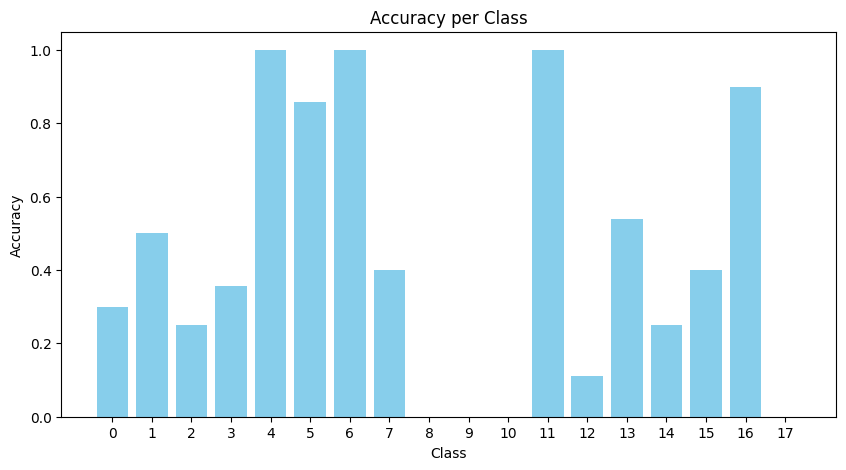

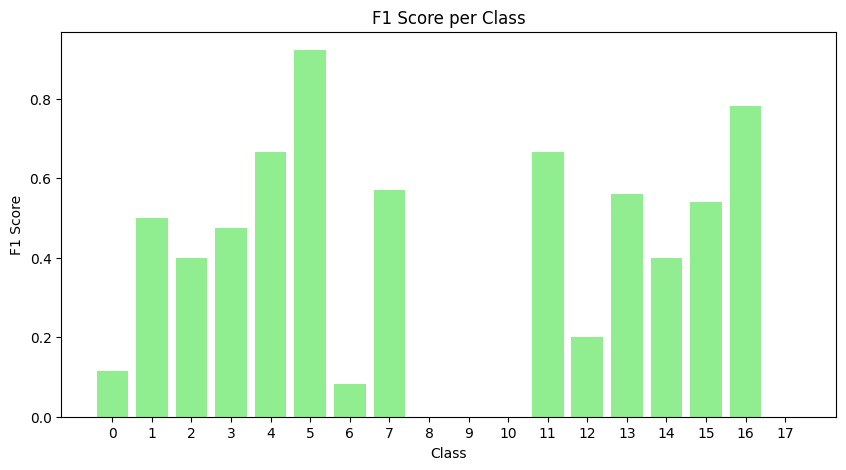

In [38]:
print(15*'*', 'RESULTS WITH RAG', 15*'*')
results_with_rag = generate_responses_with_rag(df=df_subset, api_key=api_key)
compute_and_plot_metrics(df=results_with_rag, output_file='metrics_with_RAG.csv')

*************** RESULTS WITHOUT RAG ***************
Overall accuracy:  0.6201550387596899
Overall F1-score:  0.597421023242996
    Class  Accuracy  F1_Score
0       0  0.100000  0.142857
1       1  1.000000  0.800000
2       2  0.500000  0.666667
3       3  0.928571  0.787879
4       4  1.000000  0.500000
5       5  1.000000  0.933333
6       6  1.000000  0.666667
7       7  0.400000  0.571429
8       8  0.375000  0.400000
9       9  0.000000  0.000000
10     10  0.111111  0.166667
11     11  1.000000  0.666667
12     12  0.555556  0.714286
13     13  0.923077  0.827586
14     14  0.250000  0.400000
15     15  0.800000  0.769231
16     16  0.800000  0.640000
17     17  0.000000  0.000000


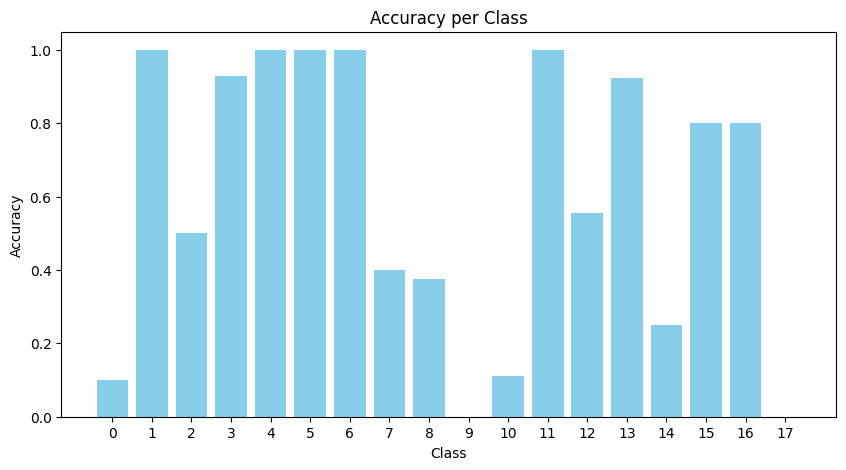

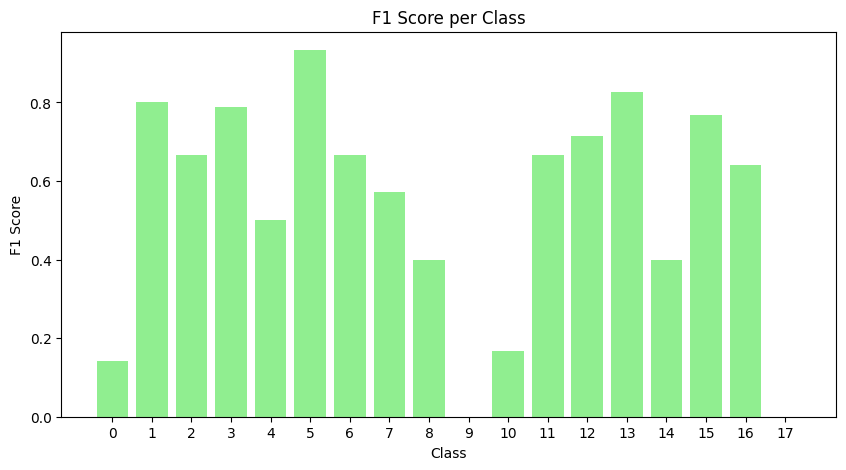

In [39]:
print(15*'*', 'RESULTS WITHOUT RAG', 15*'*')
results_without_rag = generate_responses_without_rag(df=df_subset, api_key=api_key)
compute_and_plot_metrics(df=results_without_rag, output_file='metrics_without_RAG.csv')